<a href="https://colab.research.google.com/github/mbmb7777/Anomaly-Detection/blob/main/Sensor_LSTM_AE_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **LSTM + AUTOENCODER**

In [ ]:

# Common imports
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

In [ ]:
import os
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# hide warnings
import warnings
warnings.filterwarnings('ignore')

DATASET = 환경10종 센서 중 온도, 습도, H2S, NH3, NO2

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Sensor/H2S, NH3, NO2-Single (H2S)-data-as-seriestocolumns-2021-05-17 14_49_43.csv')
merged_data = pd.DataFrame()
merged_data=merged_data.append(dataset)

# # for filename in os.listdir(data_dir):
# #     print(filename)
# #     dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
# #     dataset_mean_abs = np.array(dataset.abs().mean())
# #     dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
# #     dataset_mean_abs.index = [filename]
# #     merged_data = merged_data.append(dataset_mean_abs)

# dataset=pd.read_csv('/content/drive/MyDrive/Sensor/H2S, NH3, NO2-Single (H2S)-data-as-seriestocolumns-2021-05-17 14_49_43.csv)

# merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']

In [ ]:
dataset
#merged_data

,Time,온도,습도,H2S,NH3,NO2
0,2021-05-01 00:00:00,26,35,39,69,146
1,2021-05-01 00:10:00,26,35,49,73,143
2,2021-05-01 00:20:00,26,35,43,80,161
3,2021-05-01 00:30:00,26,35,27,71,149
4,2021-05-01 00:40:00,26,35,33,77,152
...,...,...,...,...,...,...
919,2021-05-08 23:00:00,26,33,21,65,146
920,2021-05-08 23:10:00,26,33,27,65,99
921,2021-05-08 23:20:00,26,33,16,71,120
922,2021-05-08 23:30:00,26,33,21,73,129


In [ ]:
df_date_idx = pd.read_csv('/content/drive/MyDrive/Sensor/H2S, NH3, NO2-Single (H2S)-data-as-seriestocolumns-2021-05-17 14_49_43.csv', 

                          sep=",", 

                          names=['time','temp', 'moist','H2S','NH3','NO2'], 

                          index_col=['time'], # or index_col=0 

                          parse_dates=True, 

                          dayfirst=True,

                          infer_datetime_format=True)
df_date_idx

,temp,moist,H2S,NH3,NO2
time,,,,,
Time,온도,습도,H2S,NH3,NO2
2021-05-01 00:00:00,26,35,39,69,146
2021-05-01 00:10:00,26,35,49,73,143
2021-05-01 00:20:00,26,35,43,80,161
2021-05-01 00:30:00,26,35,27,71,149
...,...,...,...,...,...
2021-05-08 23:00:00,26,33,21,65,146
2021-05-08 23:10:00,26,33,27,65,99
2021-05-08 23:20:00,26,33,16,71,120


In [ ]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=df_date_idx.index, y=df_date_idx['temp'], name='temp',opacity=0.7))
fig2.add_trace(go.Scatter(x=df_date_idx.index, y=df_date_idx['moist'], name='moist',opacity=0.7))
fig2.add_trace(go.Scatter(x=df_date_idx.index, y=df_date_idx['H2S'], name='H2S',opacity=0.7))
fig2.add_trace(go.Scatter(x=df_date_idx.index, y=df_date_idx['NH3'], name='NH3',opacity=0.7))
fig2.add_trace(go.Scatter(x=df_date_idx.index, y=df_date_idx['NO2'], name='NO2',opacity=0.7))

fig2.update_layout(title='sensor dataset',hovermode='x',template='plotly_white',xaxis=dict(mirror=True,linewidth=0.5,linecolor='white',showgrid=False,title='Time'),
                 yaxis=dict(mirror=True,linewidth=0.5,linecolor='aliceblue',title=''))
fig2.show()

In [ ]:
all= df_date_idx['2021-05-01 00:00:00': '2021-05-08 23:50:00']
train = df_date_idx['2021-05-01 00:00:00': '2021-05-04 00:00:00']
test = df_date_idx['2021-05-04 00:00:00':]
print("Training data shape:", train.shape)
print("Test data shape:", test.shape)

Training data shape: (349, 5)
Test data shape: (576, 5)


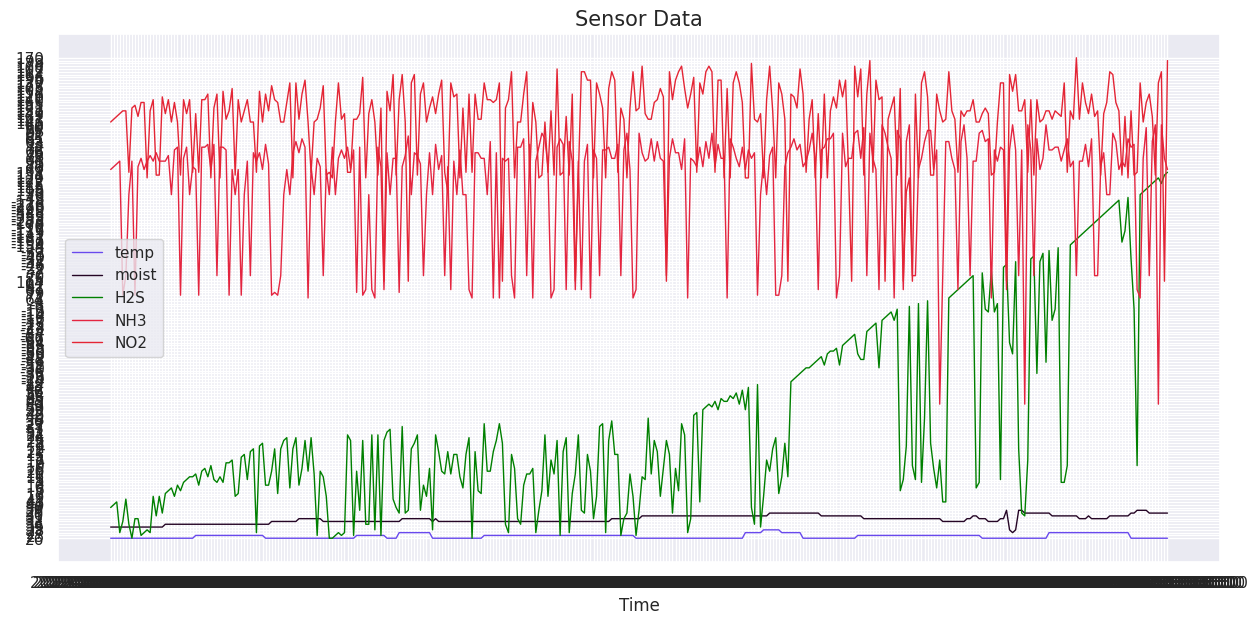

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=100)
ax.plot(train['temp'], label='temp', color='#6949ed', animated = True, linewidth=1)
ax.plot(train['moist'], label='moist', color='#250525', animated = True, linewidth=1)
ax.plot(train['H2S'], label='H2S', color='green', animated = True, linewidth=1)
ax.plot(train['NH3'], label='NH3', color='#e42540', animated = True, linewidth=1)
ax.plot(train['NO2'], label='NO2', color='#e42535', animated = True, linewidth=1)
plt.xlabel('Time')
plt.legend()
ax.set_title('Sensor Data', fontsize=15)
plt.show()

In [ ]:
all_fft = np.fft.fft(all)
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)


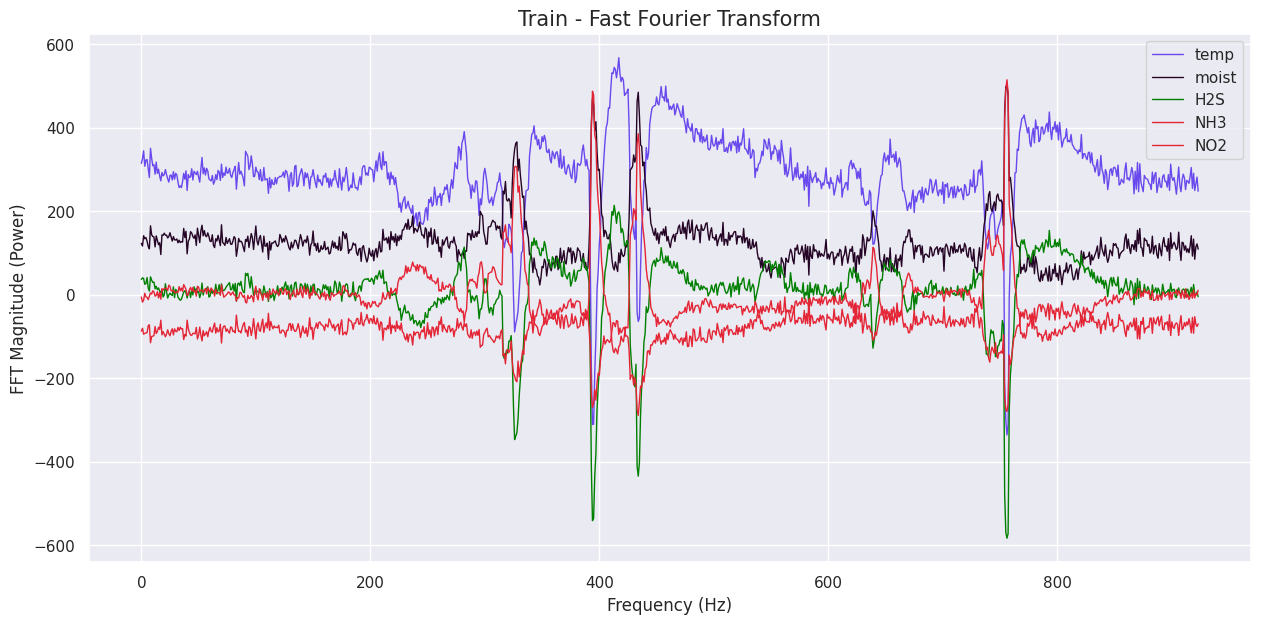

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=100)
ax.plot(all_fft[:,0].real, label='temp', color='#6949ed', animated = True, linewidth=1)
ax.plot(all_fft[:,1].imag, label='moist', color='#250525', animated = True, linewidth=1)
ax.plot(all_fft[:,2].imag, label='H2S', color='green', animated = True, linewidth=1)
ax.plot(all_fft[:,3].real, label='NH3', color='#e42535', animated = True, linewidth=1)
ax.plot(all_fft[:,4].real, label='NO2', color='#e42535', animated = True, linewidth=1)
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Magnitude (Power)')
ax.set_title('Train - Fast Fourier Transform', fontsize=15)
plt.show()

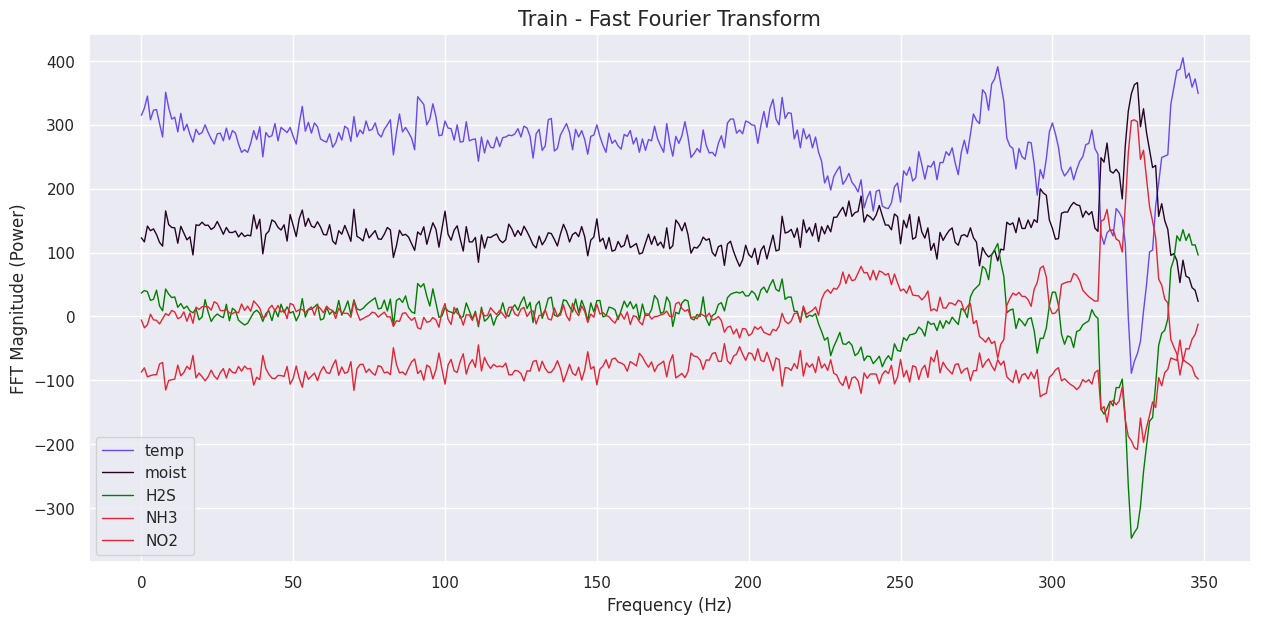

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=100)
ax.plot(train_fft[:,0].real, label='temp', color='#6949ed', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='moist', color='#250525', animated = True, linewidth=1)
ax.plot(train_fft[:,2].imag, label='H2S', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='NH3', color='#e42535', animated = True, linewidth=1)
ax.plot(train_fft[:,4].real, label='NO2', color='#e42535', animated = True, linewidth=1)
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Magnitude (Power)')
ax.set_title('Train - Fast Fourier Transform', fontsize=15)
plt.show()


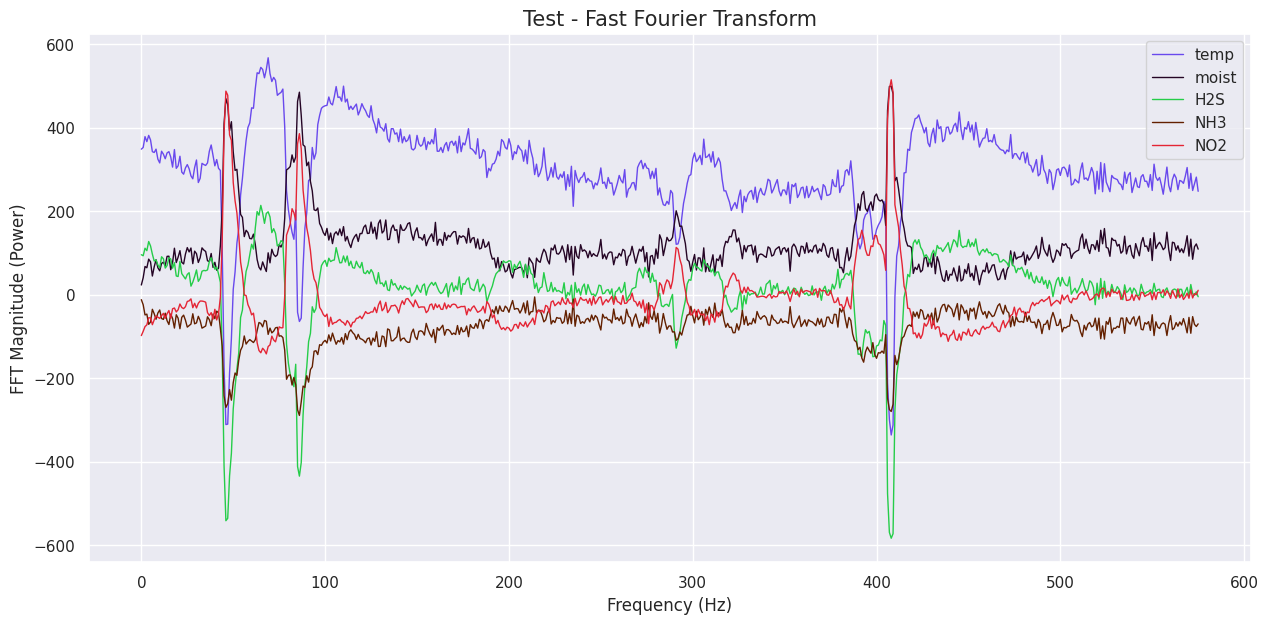

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=100)
ax.plot(test_fft[:,0].real, label='temp', color='#6949ed', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='moist', color='#250525', animated = True, linewidth=1)
ax.plot(test_fft[:,2].imag, label='H2S', color='#25cd49', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='NH3', color='#632000', animated = True, linewidth=1)
ax.plot(test_fft[:,4].real, label='NO2', color='#e42535', animated = True, linewidth=1)
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Magnitude (Power)')
ax.set_title('Test - Fast Fourier Transform', fontsize=15)
plt.show()

In [ ]:
# normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [ ]:
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (349, 5)
Test data shape: (576, 5)


In [ ]:
#reshape inputs for LSTM

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (349, 1, 5)
Test data shape: (576, 1, 5)


In [ ]:
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

In [ ]:
#define autoencoder network model
#create autoencoder model

L1 = LSTM(32, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.00))(inputs)
L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
L3 = RepeatVector(X_train.shape[1])(L2)
L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
L5 = LSTM(32, activation='relu', return_sequences=True)(L4)
output = TimeDistributed(Dense(X_train.shape[2]))(L5)    
model = Model(inputs=inputs, outputs=output) #instantiate
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 5)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 32)             4864      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 592       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 32)             4736      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 5)              165   

In [ ]:
#fit model to the data
batch_size= 16
epochs= 100
history= model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_split=0.05).history

Epoch 1/100
21/21 [==============================] - 5s 49ms/step - loss: 0.5265 - val_loss: 0.4687
Epoch 2/100
21/21 [==============================] - 0s 6ms/step - loss: 0.4976 - val_loss: 0.4422
Epoch 3/100
21/21 [==============================] - 0s 6ms/step - loss: 0.4784 - val_loss: 0.4097
Epoch 4/100
21/21 [==============================] - 0s 6ms/step - loss: 0.4426 - val_loss: 0.3681
Epoch 5/100
21/21 [==============================] - 0s 6ms/step - loss: 0.4001 - val_loss: 0.3071
Epoch 6/100
21/21 [==============================] - 0s 6ms/step - loss: 0.3377 - val_loss: 0.2161
Epoch 7/100
21/21 [==============================] - 0s 6ms/step - loss: 0.2186 - val_loss: 0.2137
Epoch 8/100
21/21 [==============================] - 0s 6ms/step - loss: 0.1592 - val_loss: 0.2083
Epoch 9/100
21/21 [==============================] - 0s 6ms/step - loss: 0.1328 - val_loss: 0.1932
Epoch 10/100
21/21 [==============================] - 0s 6ms/step - loss: 0.1313 - val_loss: 0.1922
Epoch 11

In [ ]:
model.save('vibModel.h5')

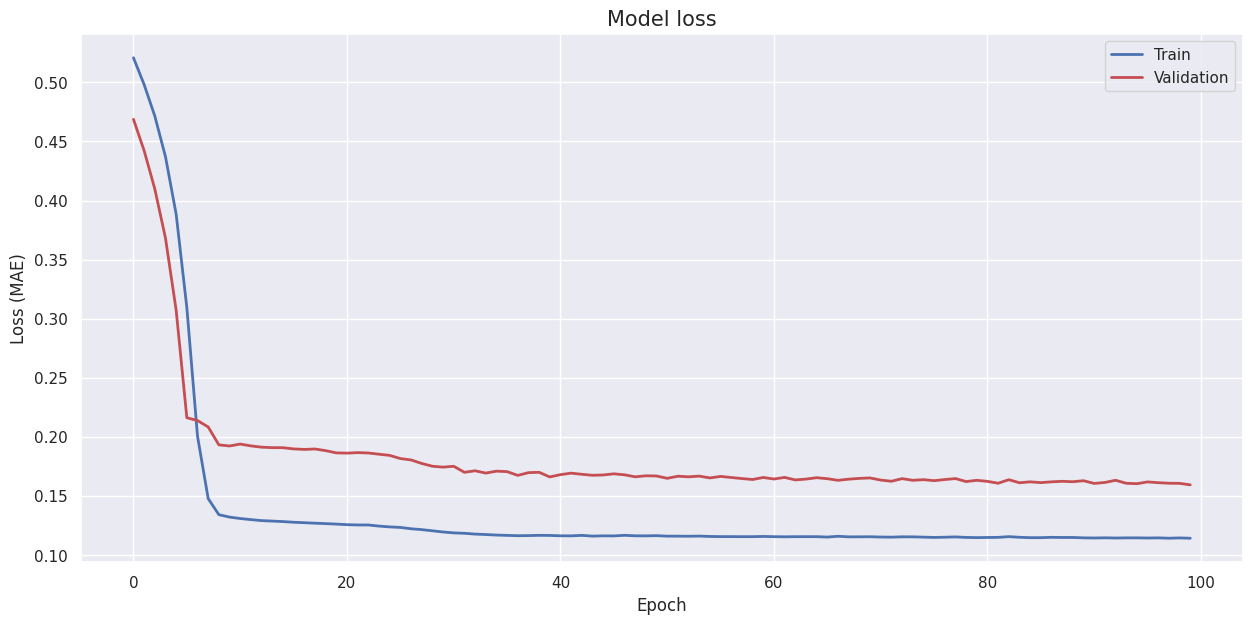

In [ ]:
#plot the training losses to evaluate our model's performance
#MAE: Mean Absolute Error(평균절대비오차)
#MAE=(예측값-실제값)의 절댓값 평균

fig, ax = plt.subplots(figsize=(15, 7), dpi=100)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=15)
ax.set_ylabel('Loss (MAE)')
ax.set_xlabel('Epoch')
ax.legend()
plt.show()

In [ ]:
#plot the loss distribution of the training set

X_pred_train = model.predict(X_train)
X_pred_train.shape

(349, 1, 5)

In [ ]:
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

score = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
score['loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)

In [ ]:
X_pred_train

,temp,moist,H2S,NH3,NO2
time,,,,,
2021-05-01 00:00:00,0.328170,0.783493,0.770656,0.673226,0.588746
2021-05-01 00:10:00,0.322981,0.836126,0.764163,0.752769,0.630666
2021-05-01 00:20:00,0.302102,0.979946,0.721100,0.983445,0.744472
2021-05-01 00:30:00,0.325001,0.817590,0.767119,0.724392,0.615931
2021-05-01 00:40:00,0.312865,0.911814,0.745210,0.872295,0.690591
...,...,...,...,...,...
2021-05-03 22:50:00,0.320266,0.465047,0.687668,0.262112,0.330429
2021-05-03 23:30:00,0.317859,0.446825,0.677333,0.241893,0.315599
2021-05-03 23:40:00,0.314811,0.427822,0.661808,0.223089,0.299737


In [ ]:
df = px.data.tips()
fig = px.histogram(score, x=score['loss_mae'], marginal="box",color_discrete_sequence=['#250569'])
fig.update_layout(title_text='Loss Distribution',xaxis_title="LOSS (MAE)", yaxis_title="Density")
fig.show()

In [ ]:
X_pred = model.predict(X_test) 
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns) 
X_pred.index = test.index
testScore = pd.DataFrame(index=test.index)

In [ ]:
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
testScore['loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
testScore['Threshold'] = 0.27
testScore['Anomaly'] = testScore['loss_mae'] > testScore['Threshold']
testScore.head()

,loss_mae,Threshold,Anomaly
time,,,
2021-05-04 00:00:00,0.184247,0.27,False
2021-05-04 00:10:00,0.163458,0.27,False
2021-05-04 00:20:00,0.111127,0.27,False
2021-05-04 00:30:00,0.094142,0.27,False
2021-05-04 00:50:00,0.211674,0.27,False


In [ ]:
# aynı eşik değeri ve anomali durmunu eğitim verisinin loss değerleri için de uyguluyoruz ve ikisini tek bir veri setinde birleştiriyoruz
score['Threshold'] = 0.27
score['Anomaly'] = score['loss_mae'] > score['Threshold']
allScore = pd.concat([score, testScore])

In [ ]:
allScore

,loss_mae,Threshold,Anomaly
time,,,
2021-05-01 00:00:00,0.095340,0.27,False
2021-05-01 00:10:00,0.076679,0.27,False
2021-05-01 00:20:00,0.041020,0.27,False
2021-05-01 00:30:00,0.078962,0.27,False
2021-05-01 00:40:00,0.042152,0.27,False
...,...,...,...
2021-05-08 23:00:00,0.086101,0.27,False
2021-05-08 23:10:00,0.119305,0.27,False
2021-05-08 23:20:00,0.063611,0.27,False


In [ ]:
fig = px.line(allScore, x=allScore.index, y='loss_mae',title="sensor dataset",log_y=True, width=780)
fig.add_trace(go.Scatter(x=allScore.index, y=allScore['Threshold'], name='Threshold', line=dict(dash='dash', color=('rgb(237, 37, 75)'))))
fig.update_layout(hovermode='closest',template='plotly_white',xaxis=dict(mirror=True,linewidth=1,linecolor='white',showgrid=False, title='Time'),
                 yaxis=dict(mirror=True,linewidth=1,linecolor='white',title='MAE'))

fig.show()

(0.0, 0.5)

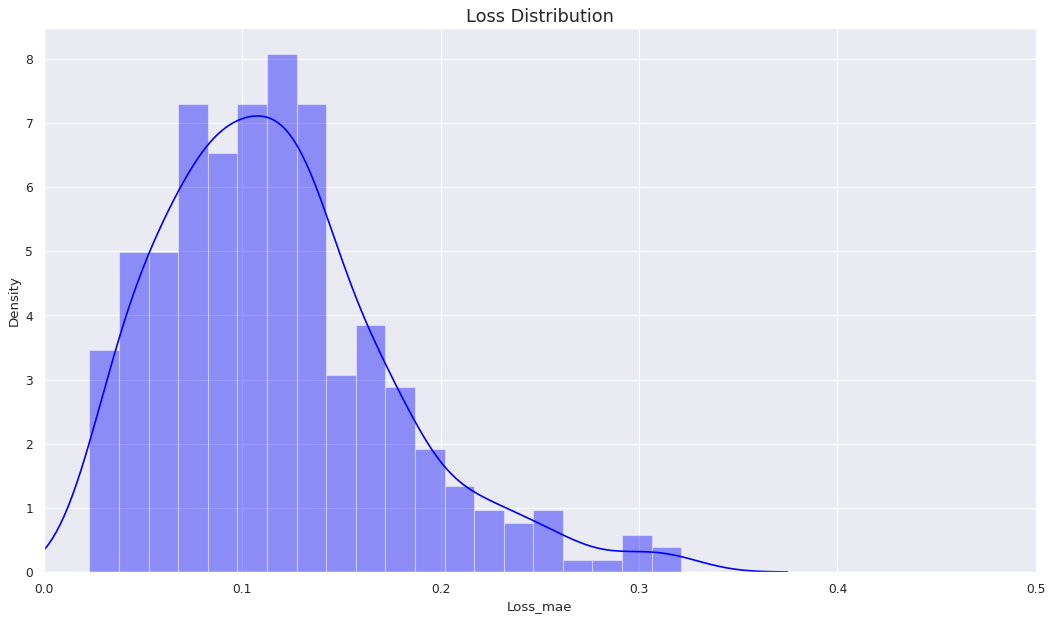

In [ ]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [ ]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
time,,,
2021-05-04 00:00:00,0.184247,0.275,False
2021-05-04 00:10:00,0.163458,0.275,False
2021-05-04 00:20:00,0.111127,0.275,False
2021-05-04 00:30:00,0.094142,0.275,False
2021-05-04 00:50:00,0.211674,0.275,False


In [ ]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

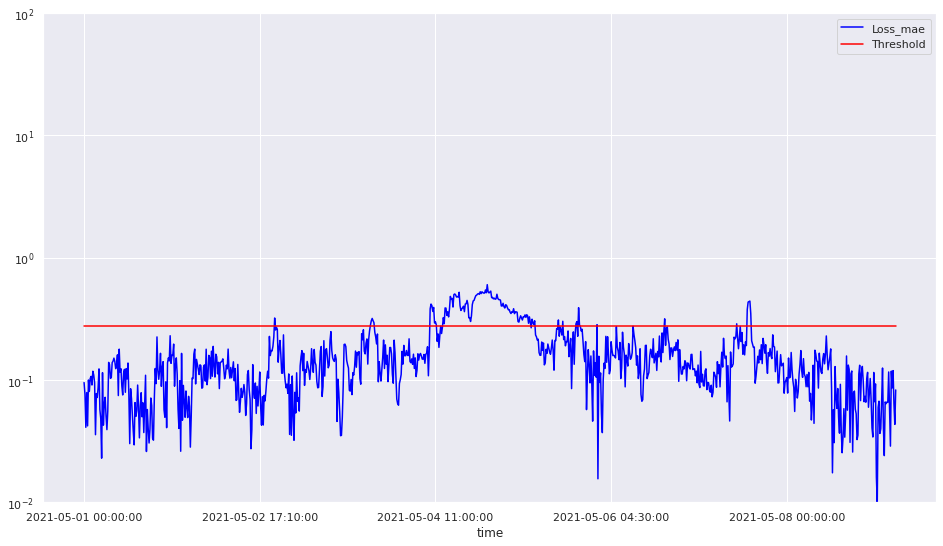

In [ ]:
# plot sensor failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

In [ ]:
# save all model information, including weights, in h5 format
model.save("sensor-anomaly-detection.csv")
print("Model saved")

INFO:tensorflow:Assets written to: sensor-anomaly-detection.csv/assets
Model saved


### **PCA**

In [ ]:
dataset_train = df_date_idx['2021-05-01 00:00:00': '2021-05-04 00:00:00']
dataset_test = df_date_idx['2021-05-04 00:00:00':]
#dataset_train.plot(figsize = (12,6))

In [ ]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

In [ ]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [ ]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [ ]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 4. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [ ]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 4. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [ ]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [ ]:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [ ]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [ ]:
mean_distr = data_train.mean(axis=0)

In [ ]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

(0.0, 15.0)

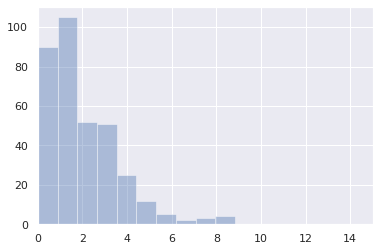

In [ ]:
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False);
plt.xlim([0.0,15])

Text(0.5, 0, 'Mahalanobis dist')

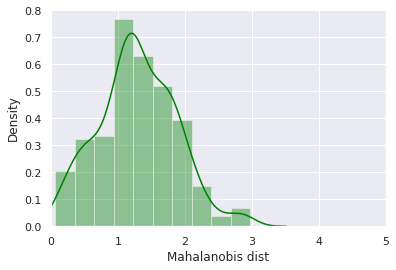

In [ ]:

plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [ ]:
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
time,,,
2021-05-04 00:00:00,1.109411,5.152832,False
2021-05-04 00:10:00,0.866114,5.152832,False
2021-05-04 00:20:00,0.905503,5.152832,False
2021-05-04 00:30:00,1.224057,5.152832,False
2021-05-04 00:50:00,2.307125,5.152832,False


In [ ]:
anomaly_alldata = pd.concat([anomaly])
anomaly_alldata.to_csv('/content/drive/MyDrive/Sensor/Anomaly_distance.csv')

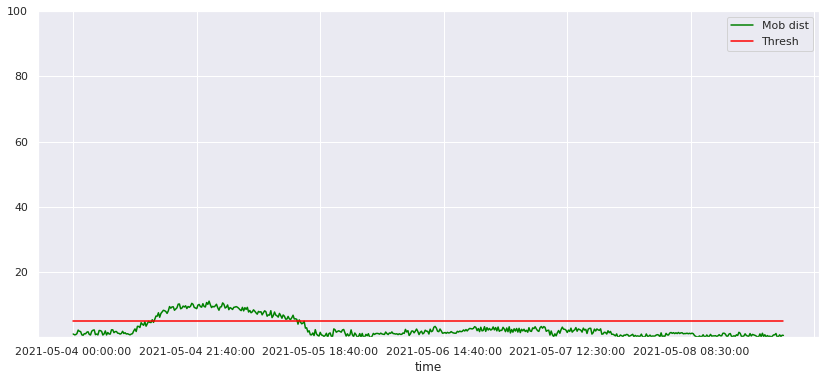

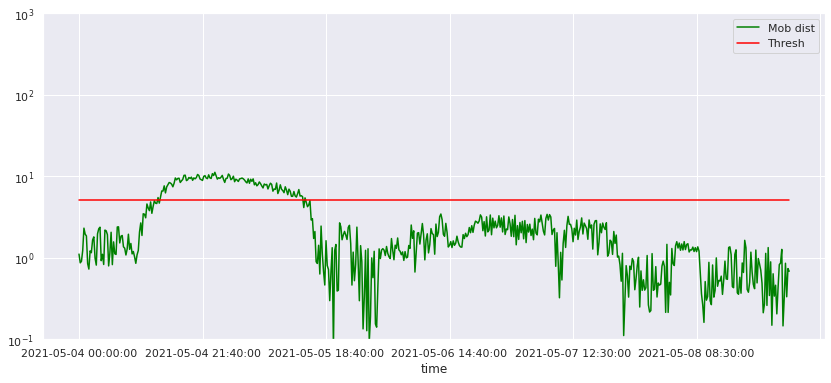

In [ ]:
#verifying PCA model in test data
anomaly_alldata.plot(figsize = (14,6), ylim = [1e-1,1e2], color = ['green','red'])
anomaly_alldata.plot(logy=True, figsize = (14,6), ylim = [1e-1,1e3], color = ['green','red'])